In [5]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from __future__ import print_function, division
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.datasets import fashion_mnist

In [8]:
class ACGAN():
    def __init__(self, input_rows, input_cols, input_channels, input_classes, latent_dim=100):
        # Input shape
        self.img_rows = input_rows
        self.img_cols = input_cols
        self.channels = input_channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = input_classes
        self.latent_dim = latent_dim

        optimizer = Adam(0.0002, 0.5)
        losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=losses,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid, target_label = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model([noise, label], [valid, target_label])
        self.combined.compile(loss=losses,
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=3, padding='same'))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, 100)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.summary()

        img = Input(shape=self.img_shape)

        # Extract feature representation
        features = model(img)

        # Determine validity and label of the image
        validity = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes+1, activation="softmax")(features)

        return Model(img, [validity, label])

    def train(self, X_train, y_train, epochs, batch_size, sample_interval):

        # Configure inputs
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        # Loss output
        g_loss_epochs = np.zeros((epochs, 1))
        d_loss_epochs = np.zeros((epochs, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # The labels of the digits that the generator tries to create an
            # image representation of
            sampled_labels = np.random.randint(0, 10, (batch_size, 1))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, sampled_labels])

            # Image labels. 0-9 if image is valid or 10 if it is generated (fake)
            img_labels = y_train[idx]
            fake_labels = 10 * np.ones(img_labels.shape)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, [valid, img_labels])
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], [valid, sampled_labels])

            #show the final losses
            g_loss_epochs[epoch] = g_loss[0]
            d_loss_epochs[epoch] = d_loss[0]

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                # Plot the progress
                print ("Epoch: %d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))
                #do not save model
                #self.save_model()
                self.sample_images(epoch, smp_rows=2, smp_cols=10, save_img=False, fig_size=(8, 8))

        return g_loss_epochs, d_loss_epochs
 

    #row, cols to be sampled
    def sample_images(self, epoch, smp_rows, smp_cols, save_img=True, fig_size=(8, 8)):
        r, c = smp_rows, smp_cols
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.array([num for _ in range(r) for num in range(c)])
        gen_imgs = self.generator.predict([noise, sampled_labels])
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        #plt.figure(figsize=fig_size)
        fig, axs = plt.subplots(r, c, figsize=fig_size)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        if save_img:
            fig.savefig("../images/%d.png" % epoch)
        else:
            #plt.figure(figsize=fig_size)
            plt.show()
        plt.close()

    def sample_single_image(self,label):
        noise = np.random.normal(0, 1, (1, 100))
        gen_imgs = self.generator.predict([noise, np.array(label).reshape((1, ))])
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        plt.imshow(gen_imgs[0, :, :, 0], cmap='gray')

    def save_model(self):
        self.generator.save('./drive/MyDrive/LIFPROJET/generator.h5')
        self.discriminator.save('./drive/MyDrive/LIFPROJET/discriminator.h5')

In [9]:
input_rows =28
input_cols =28
input_classes =10
input_channels =1
(X_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [10]:
#the instance of the ACGAN class
#we can see the Discriminator and Generator architecture
fashion_acgan = ACGAN(input_rows, input_cols, input_channels, input_classes)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 8, 8, 32)          0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 32)          0

Epoch: 0 [D loss: 3.192134, acc.: 53.12%, op_acc: 12.50%] [G loss: 3.105139]


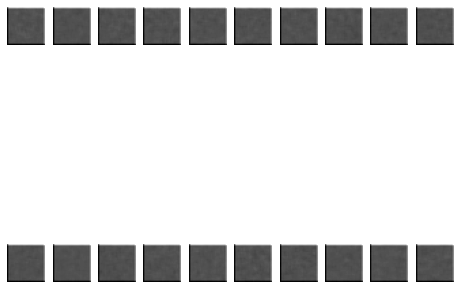

Epoch: 400 [D loss: 0.654683, acc.: 96.88%, op_acc: 84.38%] [G loss: 4.714710]


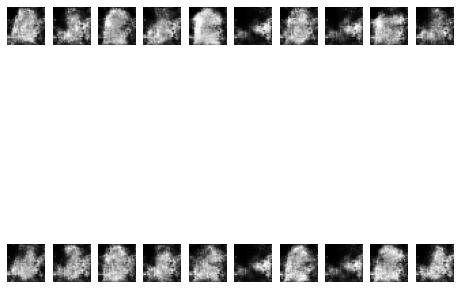

Epoch: 800 [D loss: 0.282829, acc.: 100.00%, op_acc: 87.50%] [G loss: 1.348264]


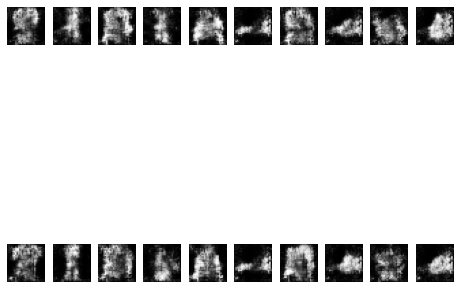

Epoch: 1200 [D loss: 0.576608, acc.: 100.00%, op_acc: 81.25%] [G loss: 0.609675]


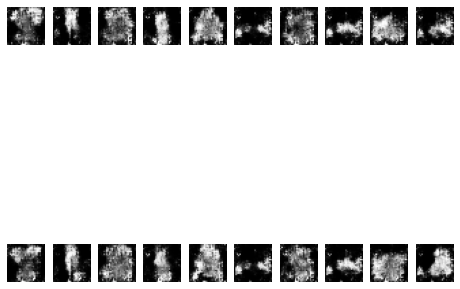

Epoch: 1600 [D loss: 0.213462, acc.: 100.00%, op_acc: 96.88%] [G loss: 0.910005]


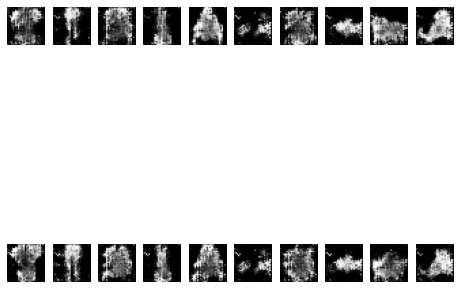

Epoch: 2000 [D loss: 0.199458, acc.: 100.00%, op_acc: 93.75%] [G loss: 0.475260]


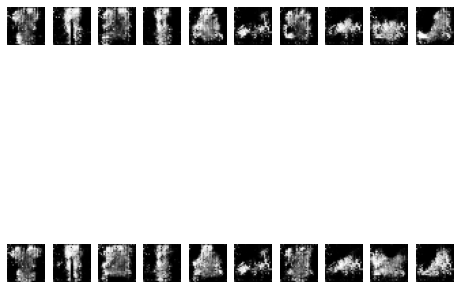

Epoch: 2400 [D loss: 0.572971, acc.: 100.00%, op_acc: 84.38%] [G loss: 1.401143]


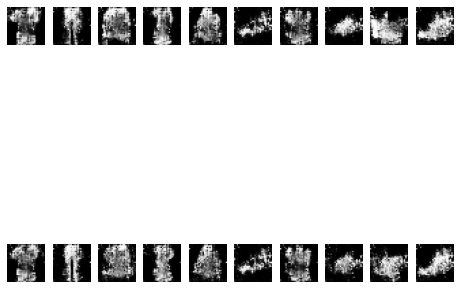

Epoch: 2800 [D loss: 0.130159, acc.: 100.00%, op_acc: 93.75%] [G loss: 0.089732]


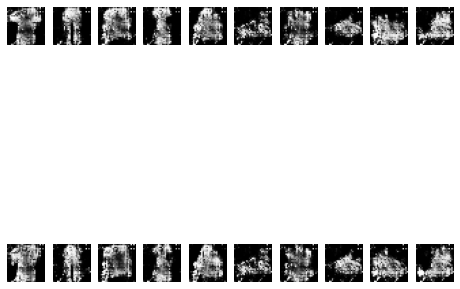

Epoch: 3200 [D loss: 0.197784, acc.: 100.00%, op_acc: 90.62%] [G loss: 1.231372]


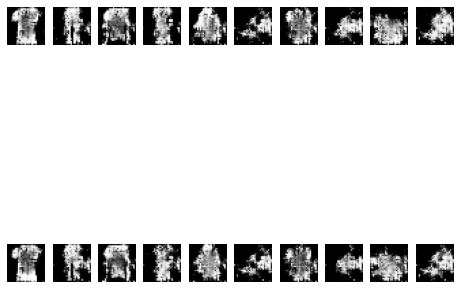

Epoch: 3600 [D loss: 0.598581, acc.: 100.00%, op_acc: 78.12%] [G loss: 1.266388]


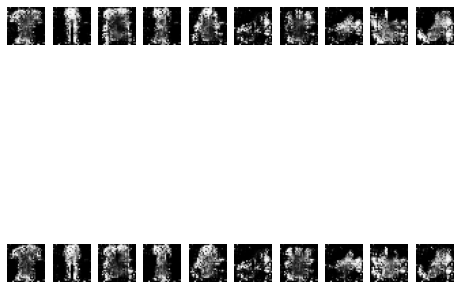

In [11]:
#Train the AC-GAN with the fashion-mnist data
g_loss, d_loss = fashion_acgan.train(X_train, y_train, epochs=4000, batch_size=16, sample_interval=400)

In [12]:
#Show the Generator-Descriminator loss for every epoch
def plot_gan_losses(g_loss, d_loss):
    plt.plot(g_loss)
    plt.plot(d_loss)
    plt.title('GAN Loss evolution')
    plt.ylabel('')
    plt.xlabel('epoch')
    plt.legend(['Generator', 'Discriminator'], loc='upper left')
    plt.show()

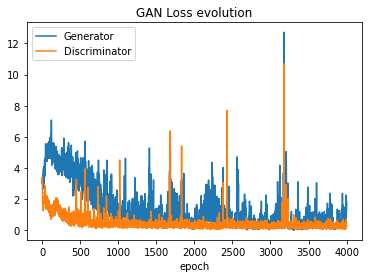

In [13]:
plot_gan_losses(g_loss, d_loss)

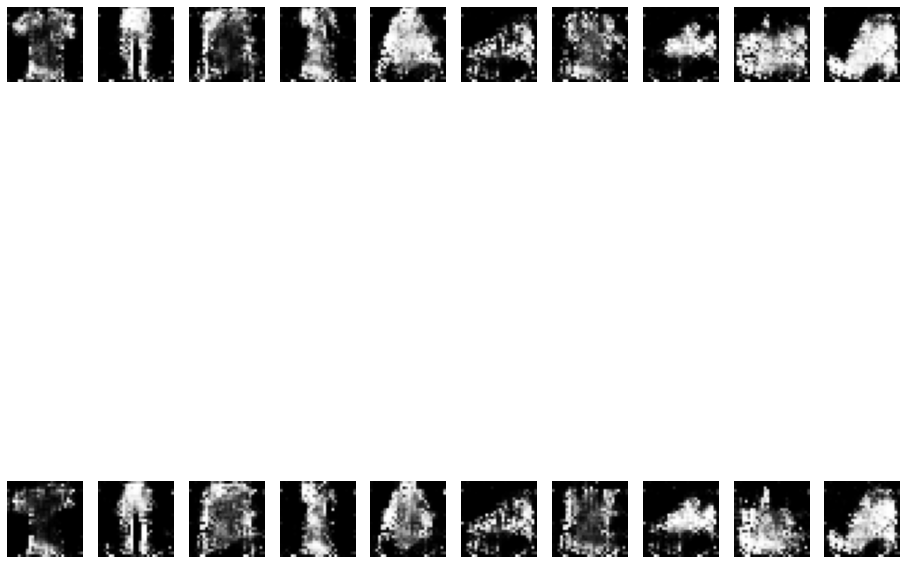

In [14]:
fashion_acgan.sample_images(epoch=0, smp_rows=2, smp_cols=10, save_img=False, fig_size=(16, 16))

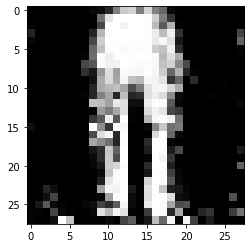

In [15]:
fashion_acgan.sample_single_image(label=1)

In [107]:
def plot_n_produit(label,N_closest):
    noise = np.random.normal(0, 1, (1, 100))
    img_smp = fashion_acgan.generator.predict([noise, np.array(label).reshape(1, )])[0, :, :, 0]
    img_smp = img_smp*0.5 + 0.5

    #get the images that belong to id_label_sample
    idx_lab = np.where(y_train==label)
    X_lab = (X_train[idx_lab, :, :].astype(np.float32) / 255)[0, :, :, :]
    
    #apply the norm between X_lab and the sampled image across all images
    L1d = np.sum(np.apply_along_axis(np.linalg.norm, -1, X_lab - img_smp, ord=1), axis=1)
    idx_l1_sort = L1d.argsort()
    fig, axs = plt.subplots(1, N_closest, figsize=(14, 14))
    for i in range(N_closest):
        axs[i].imshow(X_lab[idx_l1_sort[i], :, :], cmap='gray')
        axs[i].axis('off')

In [108]:
def plot_1_produit(label):
    noise = np.random.normal(0, 1, (1, 100))
    img_smp = fashion_acgan.generator.predict([noise, np.array(label).reshape(1, )])[0, :, :, 0]
    img_smp = img_smp*0.5 + 0.5

    #get the images that belong to id_label_sample
    idx_lab = np.where(y_train==label)
    X_lab = (X_train[idx_lab, :, :].astype(np.float32) / 255)[0, :, :, :]
    
    #apply the norm between X_lab and the sampled image across all images
    L1d = np.sum(np.apply_along_axis(np.linalg.norm, -1, X_lab - img_smp, ord=1), axis=1)
    idx_l1_sort = L1d.argsort()
    plt.imshow(X_lab[idx_l1_sort[0], :, :], cmap='gray')

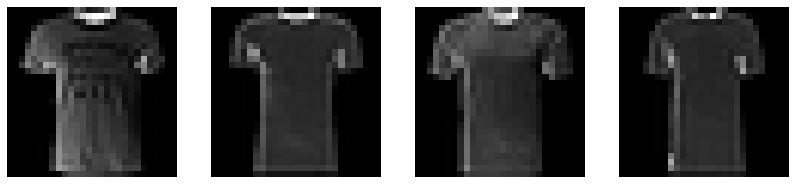

In [109]:
plot_n_produit(0, 4)

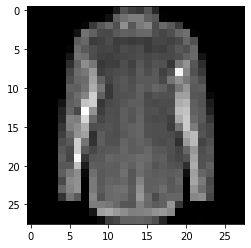

In [110]:
plot_1_produit(6)

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
import os
os.listdir("./")
os.listdir("./drive/MyDrive/LIFPROJET")

['static',
 'templates',
 'classification_modele.ipynb',
 'generator.h5',
 'discriminator.h5',
 'images']

In [ ]:
fashion_acgan.save_model()

In [111]:
def n_image_produit(label,N_closest):
    noise = np.random.normal(0, 1, (1, 100))
    img_smp = fashion_acgan.generator.predict([noise, np.array(label).reshape(1, )])[0, :, :, 0]
    img_smp = img_smp*0.5 + 0.5

    #get the images that belong to label
    idx_lab = np.where(y_train==label)
    X_lab = (X_train[idx_lab, :, :].astype(np.float32) / 255)[0, :, :, :]
    
    #apply the norm between X_lab and the sampled image across all images
    L1d = np.sum(np.apply_along_axis(np.linalg.norm, -1, X_lab - img_smp, ord=1), axis=1)
    idx_l1_sort = L1d.argsort()
    fig, axs = plt.subplots(1, N_closest, figsize=(14, 14))
    for i in range(N_closest):
        axs[i].imshow(X_lab[idx_l1_sort[i], :, :], cmap='gray')
        axs[i].axis('off')

    fig.savefig("./drive/MyDrive/LIFPROJET/images/sample_category%d.png" % label)

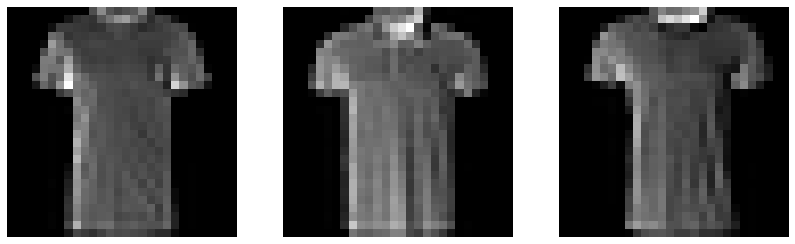

In [112]:
n_image_produit(0,3)

In [113]:
from PIL import Image
import matplotlib

def one_image_produit(label):
    noise = np.random.normal(0, 1, (1, 100))
    img_smp = fashion_acgan.generator.predict([noise, np.array(label).reshape(1, )])[0, :, :, 0]
    img_smp = img_smp*0.5 + 0.5

    #get the images that belong to label
    idx_lab = np.where(y_train==label)
    X_lab = (X_train[idx_lab, :, :].astype(np.float32) / 255)[0, :, :, :]
    
    #apply the norm between X_lab and the sampled image across all images
    L1d = np.sum(np.apply_along_axis(np.linalg.norm, -1, X_lab - img_smp, ord=1), axis=1)
    idx_l1_sort = L1d.argsort()
    img=X_lab[idx_l1_sort[0], :, :]
    matplotlib.image.imsave('./drive/MyDrive/LIFPROJET/images/COLORcategory%d.png' % label, img)
    plt.imshow(img)

    color_image=Image.open( "./drive/MyDrive/LIFPROJET/images/COLORcategory%d.png"  % label )
    bw_image=color_image.convert('L')
    bw_image.save("./drive/MyDrive/LIFPROJET/images/BWcategory%d.png"% label)
    plt.imshow(bw_image,cmap=plt.get_cmap('gray'))

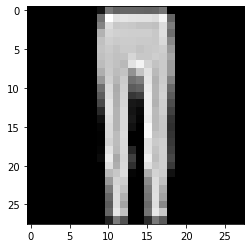

In [114]:
one_image_produit(1)